In [1]:
import matplotlib.pyplot as plt
import os
from Euhforia_Run import ALL_FOLDERS

#ROOT_PATH_SAVE_GFX = os.path.join(os.path.expanduser("~"), "local_thesis", "scratch_11_4", "gfx", "scaled_bclt_sq", "flux")
ROOT_PATH_SAVE_GFX = os.path.join(os.path.expanduser(
    "~"), "local_thesis", "scratch_11_4", "gfx", "final")

# "data", "scaled_bclt_sq", "flux"
DATA_PATH_FLUX = os.path.join(os.path.expanduser(
    "~"), "local_thesis", "scratch_11_4", "data", "flux")
CME_SIDES = ["minus", "plus"]

BTypes = ["Blon", "Bclt"]
BType_to_fluxType = {"Blon":"Toroidal", "Bclt":"Poloidal"}


def readtxt(path_to_txt):
    """returns tuple of xdata, ydata, xlabel and ylabel.
    reads in txt file data

    Args:
        path_to_txt (str): path to txt file
    """
    with open(path_to_txt, "r") as f:
        txtFile = f.readlines()

    txtFile = [line.replace('\n', '') for line in txtFile]

    idx = txtFile[2].rfind(" ")+1
    y_label = txtFile[1][idx:]
    x_label = txtFile[1][:idx]
    x_label = x_label.strip()

    # separate x and y per line
    txtFile = [line.split() for line in txtFile if line and line[0].isdigit()]

    # make float from str for every number
    txtFile = [[abs(float(num)) for num in line] for line in txtFile]

    # seperate [data_pt_1, data_pt_2, ..., data_pt_n] into [x_1, ..., x_n] and [y_1, ..., y_n]
    xdata, ydata = zip(*txtFile)
    return xdata, ydata, x_label, y_label


In [51]:
# Util

#! weird thing with integration data only saved from t=7... # 7 for sq blanking
TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME = 0


def get_derivative(y, idx=0):    
    y_filtered = y[idx:]
    return [y - y_filtered[i] for i, y in enumerate(y_filtered[1:])]


def get_relative_derivative(y, idx=0):
    y_max = max(y)
    y_filtered = y[idx:]
    return [(y - y_filtered[i])/y_max for i, y in enumerate(y_filtered[1:])]


def get_flux_data(run_name, B_type):
    files = [os.path.join(DATA_PATH_FLUX, run_name + "-flux-" +
                        BType_to_fluxType[B_type].lower() + "-" + side + ".txt") for side in CME_SIDES]

    x, y_minus, x_label, _ = readtxt(files[0])
    _, y_plus, _, _ = readtxt(files[1])

    return x, y_minus, y_plus, x_label


def process_boundaries(run_name, y, part_of_cme_index, using_ct_lwrBnd=False, ct_lwrBnd=10):
    """returns indices of boundary for the fitting  

    Args:
        run_name (str)
        y (list of data points)
        part_of_cme_index (int): 0 = front side, 1 = back side
    """
    index_min = y.index(max(y))+1
    index_max = run_limits_fits[run_name][part_of_cme_index]
    index_max -= TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME
    if index_max == 0:
        index_max = len(y)

    if using_ct_lwrBnd:
        index_min = ct_lwrBnd - TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME
        # lower bnd must be >= 0
        index_min = max(0, index_min)

    return index_min, index_max


def correct_index(index, subtract_time_offest=True):
    """Checks if index is valid. Subtracts time offset and checks if the outcome
    of this is below zero. If so, sets index to zero.
    Returns corrected index

    Args:
        index (int): index to be corrected
        subtract_time_offest (bool, optional): Whether to subtract any time offset in data set. 
            Defaults to True.
        time_offset (int, optional): Time offset of data set.
            Defaults to global variable.
    """
    if subtract_time_offest:
        index -= TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME
    index = max(0, index) # index = 0 if index < 0
    return index


def process_boundaries_v2(run_name, y, part_of_cme_index=0, using_ct_lwrBnd=False, ct_lwrBnd=0):
    """returns indices of boundary for the fitting. Works with B1  

    Args:
        run_name (str)
        y                   : does not do anything, included for compatibility
        part_of_cme_index   : does not do anything, included for compatibility
        using_ct_lwrBnd     : does not do anything, included for compatibility
        ct_lwrBnd           : does not do anything, included for compatibility
    """
    index_min = correct_index(run_limits_fits_new[run_name][0])
    index_max = correct_index(run_limits_fits_new[run_name][1])
    return index_min, index_max


def get_slices(x, delta, idx_min, idx_max):
    """returns sliced x and delta based on indices given

    Args:
        x (data): 
        delta (data): 
        idx_min (lower boundary, int)
        idx_max (upper boundary, int)
    """
    L = len(x) - len(delta)
    x_slice = x[idx_min:idx_max]
    delta_slice = delta[:idx_max-L+1]
    return x_slice, delta_slice, L

# limits in time
# beginning well-defined
# end in this dict:
# run_name: [minus, plus]
# ! criteria: 
# ! 1) part of CME leaves the simulation domain 
# ! 2) no CME left 
run_limits_fits = {
    "mass111": [44, 0],
    "mass112": [46, 0],
    "mass113": [47, 0],
    "mass121": [37, 52],
    "mass122": [39, 51],
    "mass123": [41, 54],
    "mass131": [11, 12],
    "mass132": [15, 16],
    "mass133": [18, 20],
    "mass211": [43, 55],
    "mass212": [44, 53],
    "mass213": [44, 53],
    "mass221": [37, 48],
    "mass222": [38, 50],
    "mass223": [40, 51],
    "mass231": [14, 15],
    "mass232": [20, 24],
    "mass233": [23, 30],
    "mass311": [42, 52],
    "mass312": [43, 52],
    "mass313": [44, 52],
    "mass321": [36, 46],
    "mass322": [38, 49],
    "mass323": [40, 51],
    "mass331": [15, 17],
    "mass332": [22, 28],
    "mass333": [24, 32],
}

# run_limits_fits_new : 
# [t_begin, t_end]
# t_begin:  CME has completely entered simulation domain
# t_end:    CME has started leaving simulation domain
run_limits_fits_new = {
    "mass111": [9, 44],
    "mass112": [11, 46],
    "mass113": [11, 47],
    "mass121": [9, 37],
    "mass122": [10, 39],
    "mass123": [11, 41],
    "mass131": [9, 11],
    "mass132": [10, 15],
    "mass133": [11, 18],
    "mass211": [ 9, 43],
    "mass212": [11, 44],
    "mass213": [11, 44],
    "mass221": [10, 37],
    "mass222": [10, 38],
    "mass223": [11, 40],
    "mass231": [ 9, 14],
    "mass232": [11, 20],
    "mass233": [12, 23],
    "mass311": [10, 42],
    "mass312": [11, 43],
    "mass313": [11, 44],
    "mass321": [10, 36],
    "mass322": [11, 38],
    "mass323": [11, 40],
    "mass331": [12, 15],
    "mass332": [12, 22],
    "mass333": [12, 24],
}

# from blanking bclt < 5
run_limits_fits_old_blanking = {
    "mass111": [49, 52],
    "mass112": [51, 56],
    "mass113": [50, 53],
    "mass121": [45, 53],
    "mass122": [43, 0],
    "mass123": [42, 0],
    "mass131": [11, 12],
    "mass132": [15, 37],
    "mass133": [18, 29],
    "mass211": [44, 49],
    "mass212": [44, 45],
    "mass213": [44, 40],
    "mass221": [38, 53],
    "mass222": [38, 50],
    "mass223": [40, 55],
    "mass231": [14, 15],
    "mass232": [20, 24],
    "mass233": [23, 30],
    "mass311": [42, 42],
    "mass312": [43, 46],
    "mass313": [44, 41],
    "mass321": [36, 51],
    "mass322": [38, 56],
    "mass323": [40, 0],
    "mass331": [15, 17],
    "mass332": [22, 29],
    "mass333": [25, 34],
}


In [50]:
f=3
def test(a=f):
    print(a)
test()
f=5
test()

3
3


In [3]:
def solutionTime_to_realTime(ts):
    return [t*3 for t in ts], "Time (h)"

def rescale_flux(ys):
    CONVERSION_FACTOR = 2.23795 # 10**(-9) T/nT * (1.49598e11 m/AU)**2
    return [y * CONVERSION_FACTOR for y in ys], r"Flux ($10^{13}$ T m$^2$)"

# Plot Flux

c:\Users\yarri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


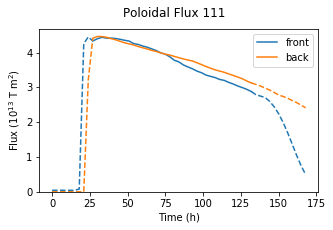

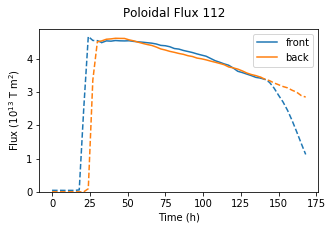

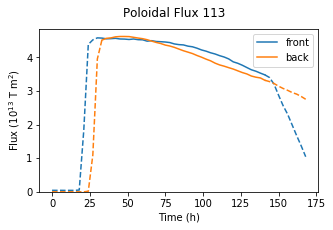

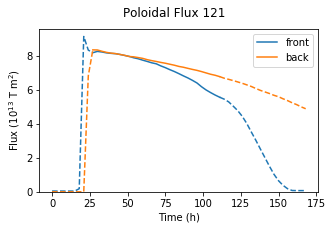

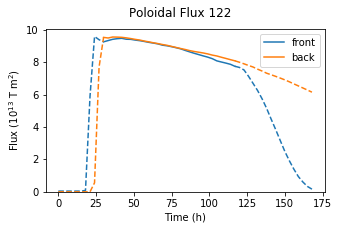

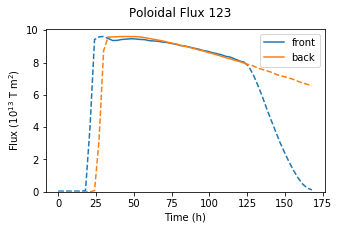

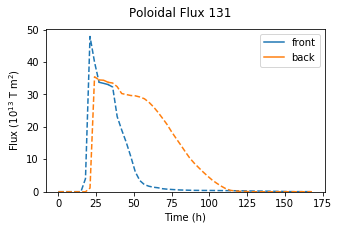

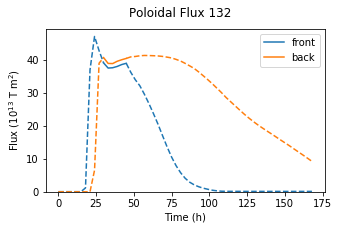

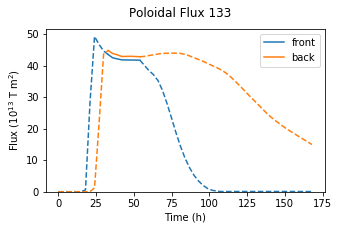

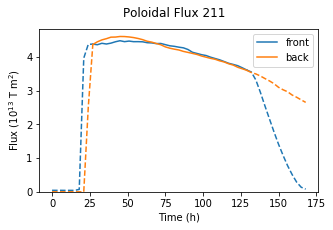

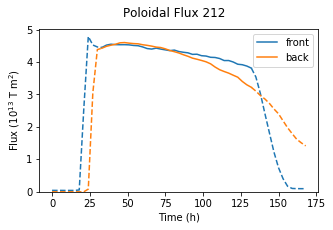

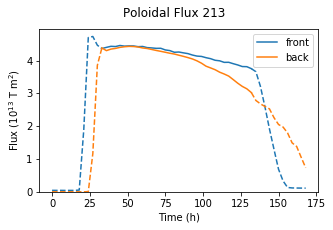

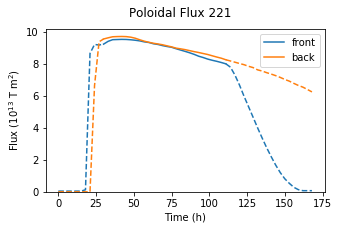

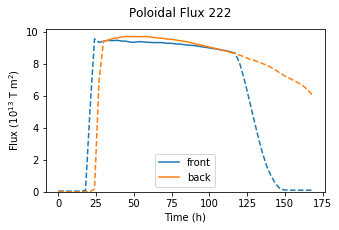

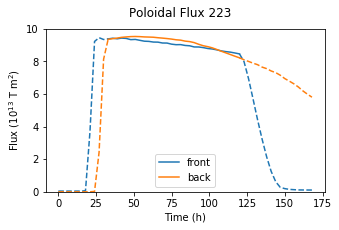

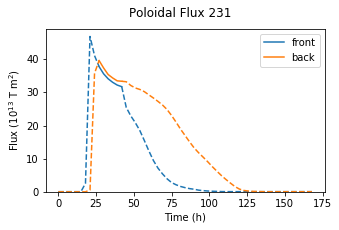

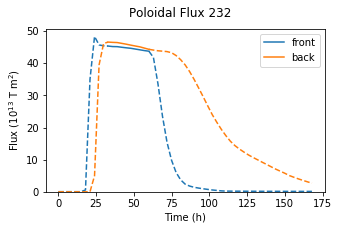

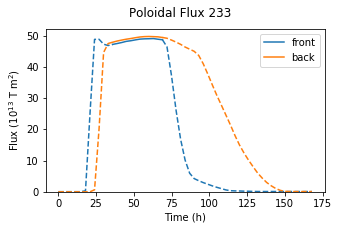

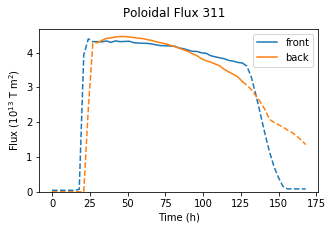

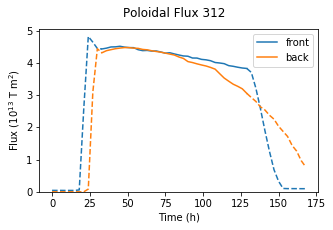

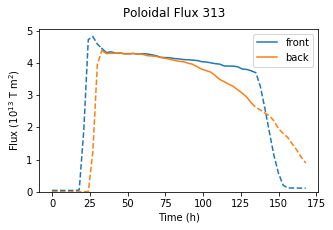

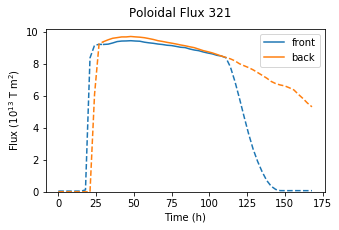

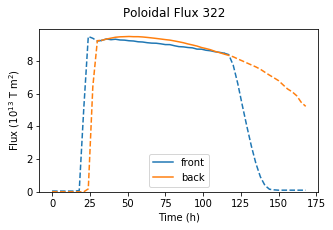

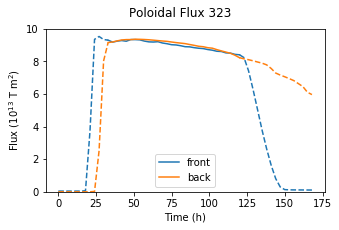

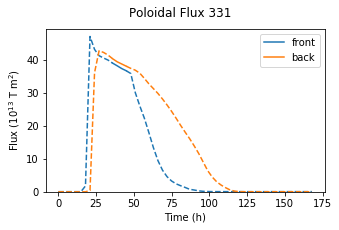

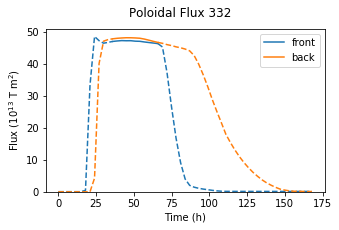

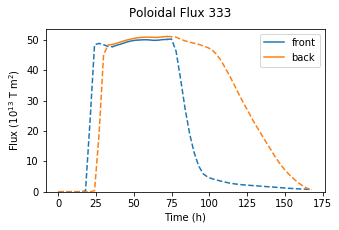

In [4]:
for B_type in ["Bclt"]:
    for run_name in ALL_FOLDERS:
        files = [os.path.join(DATA_PATH_FLUX, run_name + "-flux-" +
                              BType_to_fluxType[B_type].lower() + "-" + side + ".txt") for side in CME_SIDES]

        x, y_minus, x_label, y_label = readtxt(files[0])
        x, x_label = solutionTime_to_realTime(x)
        _, y_plus, x_label_, y_label_ = readtxt(files[1])
        del x_label_, y_label_
        
        plt.figure(figsize=(5,3))
        
        for y_i, (y, y_label, color) in enumerate(zip([y_minus, y_plus], ["front", "back"], ["tab:blue", "tab:orange"])):
            # rescale y
            y, y_ax_label = rescale_flux(y)

            #index = 3 # y.index(max(y))
            # ! changed this process boundaries function!
            low_idx, upp_idx = process_boundaries_v2(run_name, y, y_i, using_ct_lwrBnd=True)
            plt.plot(x[:low_idx+1], y[:low_idx+1], color=color, ls="--")
            plt.plot(x[low_idx:upp_idx+1], y[low_idx:upp_idx+1],
                     color=color, label=y_label, ls="-")
            plt.plot(x[upp_idx:], y[upp_idx:], color=color, ls="--")
            
                
        plt.xlabel(x_label)
        plt.ylabel(y_ax_label)
        plt.legend()
        plt.suptitle(BType_to_fluxType[B_type] + " Flux " + run_name[-3:])
        
        _, t = plt.ylim()
        plt.ylim(0, t)
        # plt.savefig(os.path.join(ROOT_PATH_SAVE_GFX, "flux-final-B1", run_name+"-flux-" +
        #             BType_to_fluxType[B_type] + "-plot-v3.png"), dpi=300, bbox_inches="tight")
        # plt.close()
        

# Plot Erosion

# Fitting To the erosion Curves

* per run
* get erosion data
* get both xlimits when to fit data
* fit data
* save parameters of the fit

c:\Users\yarri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\Users\yarri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:129: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


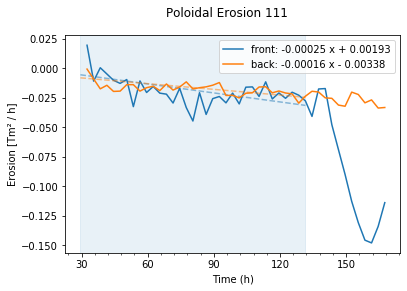

In [7]:
# newer version, easier to read
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.optimize import curve_fit


def fit_f(x, m, a):
    return m*x+a


def get_str_for_fit(popt, print_constant=True):
    m = popt[0]
    if print_constant:
        a = popt[1]
        sign = "+" if abs(a) == a else "-"
        return f"{m:.5f} x {sign} {abs(a):.5f}"
    else:
        return f"{m: .5f}"


def plot_derivative_run(run_name, B_type, saveFig=False, using_ct_lwrBnd=False, ct_lwrBnd=10):

    fit_param = {}

    # get data
    x, y_minus, y_plus, x_label = get_flux_data(run_name, B_type)
    x, x_label = solutionTime_to_realTime(x)

    # get lower limit
    LOWER_BND = min(y_minus.index(max(y_minus))+2, y_plus.index(max(y_plus))+2)
    
    if using_ct_lwrBnd:
        LOWER_BND = ct_lwrBnd
        LOWER_BND -= TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME
    
    # space x inbetween for derivative
    x = [x_i-0.5 for x_i in x[1:]]

    # new figure
    plt.figure()

    # y_minus #
    lower_bnd, upper_bnd = process_boundaries_v2(
        run_name, y_minus, 0, using_ct_lwrBnd=using_ct_lwrBnd, ct_lwrBnd=ct_lwrBnd)
    delta = get_derivative(y_minus)

    x_slice, delta_slice = x[lower_bnd:upper_bnd], delta[lower_bnd:upper_bnd]

    # fitting
    # check if enough data to fit
    if len(x_slice) > 3:
        param_opt, param_cov = curve_fit(fit_f, x_slice, delta_slice)

        plt.plot(x_slice, [fit_f(x, *param_opt)
                 for x in x_slice], ls="dashed", c="tab:blue", alpha=.5)
        fit_param["minus"] = param_opt, param_cov

        # plot fit for plus side
        if plotV2:
            temp_param_opt, _ = curve_fit(
                fit_f, x_slice, get_derivative(y_plus)[lower_bnd:upper_bnd])
            plt.plot(x_slice, [fit_f(x, *temp_param_opt)
                                 for x in x_slice], ls="dashdot", c="tab:orange", alpha=.8, 
                     label=f"back v2: {get_str_for_fit(temp_param_opt)}")

        plt.axvspan(x_slice[0], x_slice[-1], color="tab:blue", alpha=.1)

        plot_label = f"front: {get_str_for_fit(param_opt)}"
    else:
        print(run_name, "could not do fitting. Indices:", lower_bnd, upper_bnd)
        plot_label = "front"

    plt.plot(x[LOWER_BND:], delta[LOWER_BND:], c="tab:blue", label=plot_label)

    # y_plus #
    lower_bnd, upper_bnd = process_boundaries_v2(
        run_name, y_plus, 1, using_ct_lwrBnd=using_ct_lwrBnd, ct_lwrBnd=ct_lwrBnd)
    delta = get_derivative(y_plus)

    x_slice, delta_slice = x[lower_bnd:upper_bnd], delta[lower_bnd:upper_bnd]

    # fitting
    if len(x_slice) > 3:
        # check for lower amount of data points
        if plotV1:
            for ddd in range(1, plotV1_uppLim+1):
                # there must still be enough data points to do the fit
                if len(x_slice[ddd:-ddd]) <= 3:
                    continue
                temp_param_opt, _ = curve_fit(
                    fit_f, x_slice[ddd:-ddd], delta_slice[ddd:-ddd])

                plt.plot(x_slice[ddd:-ddd], [fit_f(x, *temp_param_opt)
                                             for x in x_slice[ddd:-ddd]], ls="--", c="tab:orange", alpha=.6, label=f"{len(x_slice[ddd:-ddd])} pts: {get_str_for_fit(temp_param_opt)}")

        param_opt, param_cov = curve_fit(fit_f, x_slice, delta_slice)

        if plotV0:
            plt.plot(x_slice, [fit_f(x, *param_opt)
                                 for x in x_slice], ls="dashed", c="tab:orange", alpha=.5)
        fit_param["plus"] = param_opt, param_cov
        plot_label = f"back: {get_str_for_fit(param_opt)}"
    else:
        print(run_name, "could not do fitting. Indices:", lower_bnd, upper_bnd, len(x_slice))
        plot_label = f"back"

    if plotV3:
        upper_bnd = run_limits_fits[run_name][0]
        upper_bnd -= TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME
        x_slice, delta_slice = x[lower_bnd:upper_bnd], delta[lower_bnd:upper_bnd]

        # need enough data points to fit
        if len(x_slice) > 3:
            temp_param_opt, temp_param_cov = curve_fit(
                fit_f, x_slice, delta_slice)
            plt.plot(x_slice, [fit_f(x, *temp_param_opt)
                               for x in x_slice], ls=":", c="tab:orange", alpha=.7, label=f"back v3: {get_str_for_fit(temp_param_opt)}")
            
            #! fit param should contain v3 fit values
            fit_param["plus"] = temp_param_opt, temp_param_cov

    plt.plot(x[LOWER_BND:], delta[LOWER_BND:], color="tab:orange", label=plot_label)

    # plt figure
    plt.xlabel(x_label)
    plt.ylabel("Erosion [Tm² / h]")
    plt.suptitle(BType_to_fluxType[B_type] + " Erosion " + run_name[-3:])
    plt.legend()
    plt.axes().xaxis.set_major_locator(MultipleLocator(30))
    plt.axes().xaxis.set_minor_locator(MultipleLocator(6))


    if saveFig:
        plt.savefig(os.path.join(ROOT_PATH_SAVE_GFX, "erosion-final",
                    BType_to_fluxType[B_type] + run_name[-3:] + "_Erosion_plot_fits.png"), dpi=650)
        plt.close()
    return fit_param


# plus: fit to boundaries
plotV0 = True

# plus: fit with diff added margin to the boundaries
plotV1 = False
plotV1_uppLim = 6

# plus: fit to boundaries of minus
plotV2 = False

# plus: fit to [lower bound of plus, upper bound of minus]
plotV3 = False

fit_param = {}
for B_type in ["Bclt"]:
    for run_name in ALL_FOLDERS:
        if run_name[-2] == "3":
            #! don't analyze x3x runs anymore
            continue

        
        fit_param[run_name] = plot_derivative_run(
            run_name, B_type, saveFig=False, using_ct_lwrBnd=True, ct_lwrBnd = 10)
        break

# Fitting to the Flux Curves

In [ ]:
def plot_fit_flux_run(run_name, B_type, saveFig=False, using_ct_lwrBnd=False, ct_lwrBnd=10):

    fit_param = {}

    # get data
    x, y_minus, y_plus, x_label = get_flux_data(run_name, B_type)
    x, x_label = solutionTime_to_realTime(x)
    y_minus, y_ax_label = rescale_flux(y_minus)
    y_plus, _ = rescale_flux(y_plus)

    lower_bnd, upper_bnd = process_boundaries_v2(
        run_name, y_minus, 0, using_ct_lwrBnd=using_ct_lwrBnd, ct_lwrBnd=ct_lwrBnd)    
    
    if upper_bnd - lower_bnd < 3:
        print(f"cannot do fitting, too little data {upper_bnd - lower_bnd}")
        return

    # new figure
    plt.figure()

    # fit to lower_bnd:upper_bnd
    x_slice = x[lower_bnd:upper_bnd]
    y_minus_slice = y_minus[lower_bnd:upper_bnd]
    y_plus_slice = y_plus[lower_bnd:upper_bnd]
    y_lim_min = 1e100
    y_lim_max = 0
    for y, y_slice, side, label, color in zip(
        [y_minus, y_plus], [y_minus_slice, y_plus_slice],
        ["minus", "plus"], ["front", "back"], ["tab:blue", "tab:orange"]):

        # fit to slice
        param_opt, param_cov = curve_fit(fit_f, x_slice, y_slice)

        # save fit data
        fit_param[side] = param_opt, param_cov

        # plot fit / erosion
        plt.plot(x, [fit_f(x_i, *param_opt) for x_i in x], ls="dashed", c=color, alpha=.5)
        
        # plot flux data
        plt.plot(
            x, y, c=color, label=rf"{label}: {get_str_for_fit(param_opt, print_constant=False)} ($10^{{13}}$ T m$^2$)")

        # change y_lim
        if min(y_slice) < y_lim_min:
            y_lim_min = min(y_slice)
        if max(y_slice) > y_lim_max:
            y_lim_max = max(y_slice)

    # plt figure
    y_lim_range = y_lim_max - y_lim_min
    plt.ylim(y_lim_min - .1*y_lim_range, y_lim_max+ .1*y_lim_range)
    plt.axvspan(x[lower_bnd], x[upper_bnd], color="tab:blue", alpha=.1)
    plt.xlabel(x_label)
    plt.ylabel("Erosion [Tm² / h]")
    plt.ylabel(y_ax_label)
    plt.suptitle(BType_to_fluxType[B_type] + " Erosion " + run_name[-3:])
    plt.legend()
    plt.axes().xaxis.set_major_locator(MultipleLocator(30))
    plt.axes().xaxis.set_minor_locator(MultipleLocator(6))

    if saveFig:
        plt.savefig(os.path.join(ROOT_PATH_SAVE_GFX, "erosion-final-B1",
                    BType_to_fluxType[B_type] + run_name[-3:] + "_Erosion_plot_fits.png"), dpi=650)
        plt.close()
    return fit_param


# plus: fit to boundaries
plotV0 = True

# plus: fit with diff added margin to the boundaries
plotV1 = False
plotV1_uppLim = 6

# plus: fit to boundaries of minus
plotV2 = False

# plus: fit to [lower bound of plus, upper bound of minus]
plotV3 = False

fit_param = {}
for B_type in ["Bclt"]:
    for run_name in ALL_FOLDERS:
        # if run_name[-2] == "3":
        #     #! don't analyze x3x runs anymore
        #     continue

        fit_param[run_name] = plot_fit_flux_run(
            run_name, B_type, saveFig=False, using_ct_lwrBnd=True, ct_lwrBnd=10)

## Get the total flux change due to erosion

In [54]:
def get_flux_change(run_name, B_type, using_ct_lwrBnd=False, ct_lwrBnd=0, methodB2=False):
    # get data
    x, y_minus, y_plus, x_label = get_flux_data(run_name, B_type)
    x, x_label = solutionTime_to_realTime(x)
    y_minus, y_ax_label = rescale_flux(y_minus)
    y_plus, _ = rescale_flux(y_plus)

    lower_bnd, upper_bnd = process_boundaries_v2(
        run_name, y_minus, 0, using_ct_lwrBnd=using_ct_lwrBnd, ct_lwrBnd=ct_lwrBnd)    
    
    if upper_bnd - lower_bnd < 3:
        print(f"cannot do fitting, too little data {upper_bnd - lower_bnd}")
        return
    
    # data
    fluxChange = get_empty_dict()

    # fit to lower_bnd:upper_bnd
    x_slice = x[lower_bnd:upper_bnd]
    y_minus_slice = y_minus[lower_bnd:upper_bnd]
    y_plus_slice = y_plus[lower_bnd:upper_bnd]
    
    for y, y_slice, side, label in zip(
        [y_minus, y_plus], [y_minus_slice, y_plus_slice],
        ["minus", "plus"], ["front", "back"]):

        fluxChange[side] = abs(y_slice[0] - y_slice[-1]) / y_slice[0]
        
    return fluxChange["minus"], fluxChange["plus"], getID(run_name)
    

# "data", "scaled_bclt_sq", "flux"
DATA_PATH_FLUX = os.path.join(os.path.expanduser(
    "~"), "local_thesis", "scratch_11_4", "data", "flux")
TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME = 0
print("for B1:")
fluxchanges_front = []
fluxchanges_back = []
run_ids = []
for B_type in ["Bclt"]:
    for run_name in ALL_FOLDERS:  # ALL_FOLDERS:
        if run_name[-2] == "3":
            #! don't analyze x3x runs anymore
            continue

        fluxchange_front, fluxchange_back, run_id = get_flux_change(
            run_name, B_type)
        
        fluxchanges_front.append(fluxchange_front)
        fluxchanges_back.append(fluxchange_back)
        run_ids.append(run_id)
        
for side, fluxchanges in zip(CME_SIDES, [fluxchanges_front, fluxchanges_back]):
    print(side, "\t", np.array(fluxchanges).mean(), "+-", np.array(fluxchanges).std())

# "data", "flux"
DATA_PATH_FLUX = os.path.join(os.path.expanduser(
    "~"), "local_thesis", "scratch_11_4", "data", "scaled_bclt_sq", "flux")  # ! edited
TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME = 7
print("for B2:")
fluxchanges_front = []
fluxchanges_back = []
run_ids = []
for B_type in ["Bclt"]:
    for run_name in ALL_FOLDERS:  # ALL_FOLDERS:
        if run_name[-2] == "3":
            #! don't analyze x3x runs anymore
            continue

        fluxchange_front, fluxchange_back, run_id = get_flux_change(
            run_name, B_type, methodB2=True)

        fluxchanges_front.append(fluxchange_front)
        fluxchanges_back.append(fluxchange_back)
        run_ids.append(run_id)

for side, fluxchanges in zip(["front", "back"], [fluxchanges_front, fluxchanges_back]):
    print(side, "\t", np.array(fluxchanges).mean(),
          "+-", np.array(fluxchanges).std())
# ! change these back to B1
DATA_PATH_FLUX = os.path.join(os.path.expanduser(
    "~"), "local_thesis", "scratch_11_4", "data", "flux")
TIME_OFFSET_DUE_TO_INTEGRATION_ONLY_BEGINNING_FROM_LATER_TIME = 0


for B1:
minus 	 0.15235865414439567 +- 0.07185834592990038
plus 	 0.18426017687081137 +- 0.07979802747273598
for B2:
front 	 0.0357608790069243 +- 0.022761975766579533
back 	 0.09381413348386598 +- 0.05294009113896927


# Parameter Study

* view fit pms (with their errors) 
* in function of the diff parameters of the run

## ``fit_param`` Structure

``fit_param[run_name][side_of_CME][results_curve_fit]``
- results_curve_fit: 0 = optimal value, 1 = covariance matrix 
  - [0] optimal value - [m_val, a_val]: we always want m_val [0]
  - [1] covariance matrix - 2x2 matrix: we always want variance of m_val [0][0]

In [15]:
# UTIL
from numpy import sqrt
print(f"total of {len(fit_param.keys())} runs succesfully fitted.")

radii = [10.75, 15.20, 18.62]
densities = [1e-18, 5e-18, 1e-17]
fluxes = [5e13, 1e14, 5e14]

PARAMETERS = {
    0: {
        "name": "Density",
        "values": densities,
        "ticks": [f"{density:.0E}" for density in densities],
        "unit_string": r"kg m$^3$",
        "label":["1E-18", "5E-18", "1E-17"]
    },
    1: {
        "name": "Total flux",
        "values": fluxes,
        "ticks": [f"{flux:.0E}" for flux in fluxes],
        "unit_string": r"Wb",
    },
    2: {
        "name": "Radius",
        "values": radii,
        "ticks": radii,
        "unit_string": r"$R_\odot$"
    }
}


def get_empty_dict(val=[]):
    return {"minus": val, "plus": val}


def getID(run_name: str) -> str:
    """Returns ID (str) of run from its name.
    ! DIFFERENT FROM getSpecificID & getLastID
    ! starts from 1, others start from 0
    >>> getID("mass123") 
    >>> "123"
    """
    return run_name[-3:]


def getSpecificID(run_name: str, idx: int) -> int:
    """Returns int of specific ID at idx.
    ! idx starts from 0
    idx = 0: density
    idx = 1: total flux
    idx = 2: radius 
    >>> getSpecificID("mass123", 1)
    >>> 1
    """

    return int(getID(run_name)[idx])-1


def getLastID(x: int, y: int) -> int:
    """Returns last ID not mentioned in x or y. 
    x, y and output are {0,1,2}
    ! idx starts from 0
    
    >>> getLastID(1,2)
    >>> 0
    """
    return 3 - x - y


def getLabel(pm_i, val_i, enableLabel=True):
    if not enableLabel:
        return None
    else:
        return f"{PARAMETERS[pm_i]['name']} = {PARAMETERS[pm_i]['ticks'][val_i]} {PARAMETERS[pm_i]['unit_string']}" 


total of 27 runs succesfully fitted.


c:\Users\yarri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


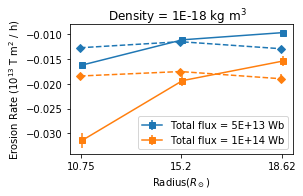

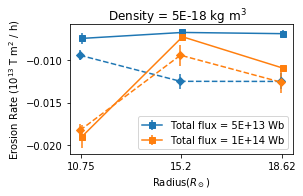

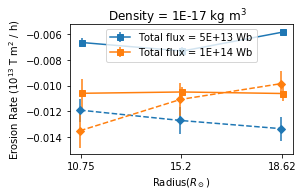

In [10]:
def pm_study(CT_PM_1, CT_PM_2, saveFig, save_folder_name="pm-study"):
    """Plots optimal parameter (the slope) of the linear fit as defined in fit_param.
    Plots with constant CT_PM_1, and diff CT_PM_2, leaving the third parameter as the x-axis value of the plots.
    There is a figure for every value of CT_PM_1.

    Args:
        CT_PM_1 (int): index of first ct pm, for which one figure per value is made 
        CT_PM_2 (int): index of second ct pm, which varies in one figure
        saveFig (bool): if figures will be saved.
    """
    for CT_VAL_1 in range(3):
        x = [get_empty_dict() for _ in range(3)]
        y = [get_empty_dict() for _ in range(3)]
        y_err = [get_empty_dict() for _ in range(3)]

        colors = ["tab:blue", "tab:orange", "tab:green"]

        plt.figure(figsize=(4, 2.4))

        for color, CT_VAL_2 in zip(colors, range(3)):
            # get data for line in the plot (2 pms constant)
            for run_name in fit_param.keys():
                # only keep data with right values for the right indices
                if getSpecificID(run_name, CT_PM_1) != CT_VAL_1:
                    continue
                if getSpecificID(run_name, CT_PM_2) != CT_VAL_2:
                    continue


                # there needs to be data (not None)
                if not fit_param[run_name]:
                    # print("None value in fit_param", run_name)
                    continue
                # fit of both + and - is necessary ATM
                if len(fit_param[run_name].keys()) != 2:
                    # print("no 2 fits in fit_param", run_name)
                    continue

                # DO NOT ADD X3X RUNS TO THIS PM STUDY
                if getSpecificID(run_name, 1) == 2:
                    # print("skipped over x3x runs:", run_name)
                    continue
                
                
                for cme_side in CME_SIDES:
                    param_val = fit_param[run_name][cme_side][0][0]
                    param_var = fit_param[run_name][cme_side][1][0][0]
                    param_std_dev = sqrt(param_var)

                    x[CT_VAL_2][cme_side].append(getSpecificID(
                        run_name, getLastID(CT_PM_1, CT_PM_2)))
                    y[CT_VAL_2][cme_side].append(param_val)
                    y_err[CT_VAL_2][cme_side].append(param_std_dev)

            # data gathered
            # plot data for line in the plot for both sides/parts
            for diff, marker, linestyle, cme_side in zip([.01,-.01], ["s", "D"], ["-", "--"], CME_SIDES):
                if len(y[CT_VAL_2][cme_side]) > 0:
                    
                    x_values = x[CT_VAL_2][cme_side]
                    x_values = [xs+diff for xs in x_values]
                    plotLabelBool = not(cme_side == "plus")
                    plt.errorbar(x_values, y[CT_VAL_2][cme_side],
                                yerr=y_err[CT_VAL_2][cme_side], marker=marker, c=color, ls=linestyle, label= getLabel(CT_PM_2, CT_VAL_2, plotLabelBool))


        plt.legend()
        plt.axes().xaxis.set_major_locator(MultipleLocator(1))
        plt.suptitle(getLabel(CT_PM_1, CT_VAL_1))

        left, right = plt.xlim()
        left, right = int(left), int(right)

        if left == 0 and right == 1:
            pass
        plt.xticks(range(left, right+1), PARAMETERS[getLastID(CT_PM_1, CT_PM_2)]["ticks"])
        plt.xlabel(PARAMETERS[getLastID(CT_PM_1, CT_PM_2)]["name"] + f"({PARAMETERS[getLastID(CT_PM_1, CT_PM_2)]['unit_string']})")
        plt.ylabel(r"Erosion Rate ($10^{13}$ T m$^2$ / h)")

        if saveFig:
            plt.savefig(os.path.join(ROOT_PATH_SAVE_GFX, save_folder_name,
                        BType_to_fluxType[B_type] + f"_{PARAMETERS[CT_PM_1]['name']}={PARAMETERS[CT_PM_1]['ticks'][CT_VAL_1]}.png"), dpi=300, bbox_inches="tight")
            plt.close()

# 0 density
# 1 flux
# 2 radius
pm_study(0,1, saveFig=False)

## Parameter study for all possible combinations

0 1
0 2


c:\Users\yarri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


1 0
1 2


2 0
2 1


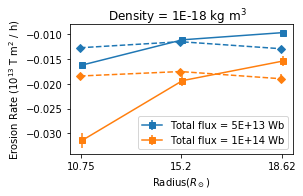

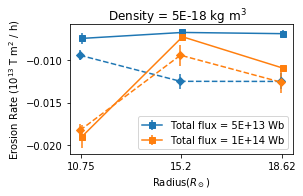

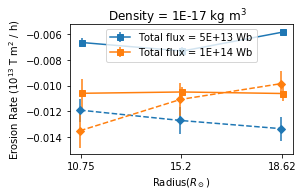

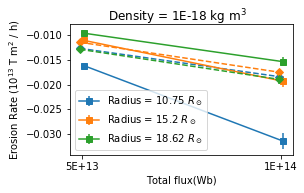

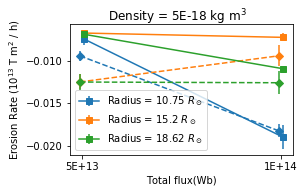

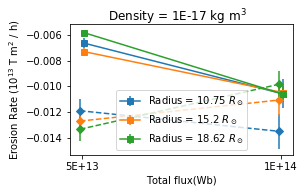

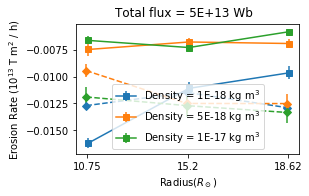

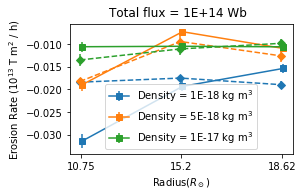

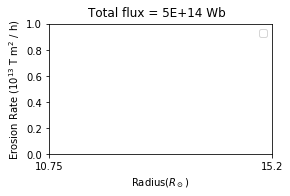

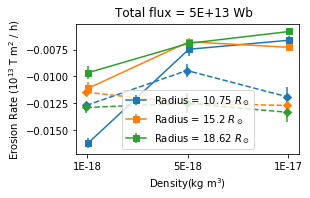

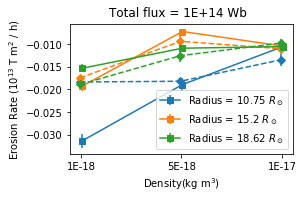

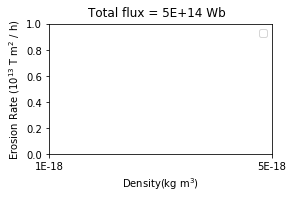

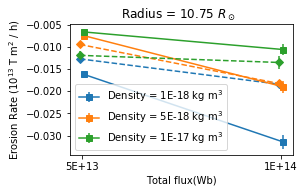

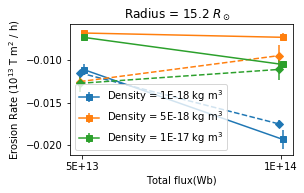

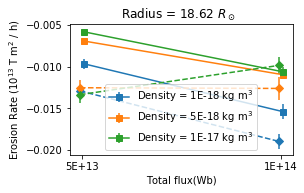

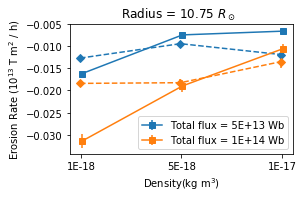

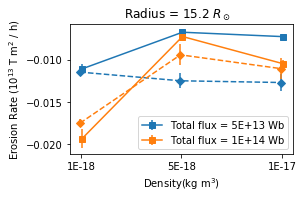

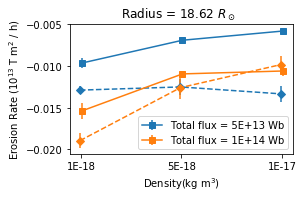

In [11]:
for pm1 in range(3):
    for pm2 in range(3):
        if pm2 == pm1:
            continue
        print( pm1, pm2)
        pm_study(pm1, pm2, saveFig=False, save_folder_name="pm_study-B1")


## In function of mass

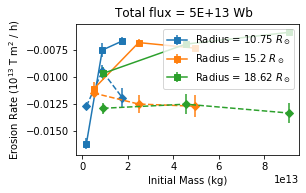

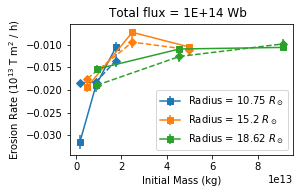

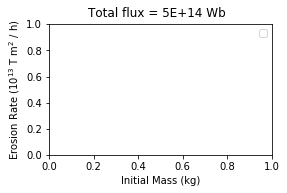

In [12]:
from math import pi
def solarR_to_m(r):
    return r * 6.957e8

def getMass(n, r):
    return n * (4/3) * pi * solarR_to_m(r)**3

def pm_study_mass(CT_PM_1, CT_PM_2, saveFig, save_folder_name="pm-study-mass"):
    """Plots optimal parameter (the slope) of the linear fit as defined in fit_param.
    Plots with constant CT_PM_1, and diff CT_PM_2, leaving the third parameter as the x-axis value of the plots.
    There is a figure for every value of CT_PM_1.

    Args:
        CT_PM_1 (int): index of first ct pm, for which one figure per value is made 
        CT_PM_2 (int): index of second ct pm, which varies in one figure
        saveFig (bool): if figures will be saved.
    """
    for CT_VAL_1 in range(3):
        x = [get_empty_dict() for _ in range(3)]
        y = [get_empty_dict() for _ in range(3)]
        y_err = [get_empty_dict() for _ in range(3)]

        colors = ["tab:blue", "tab:orange", "tab:green"]

        plt.figure(figsize=(4, 2.4))

        for color, CT_VAL_2 in zip(colors, range(3)):
            # get data for line in the plot (2 pms constant)
            for run_name in fit_param.keys():
                # only keep data with right values for the right indices
                if getSpecificID(run_name, CT_PM_1) != CT_VAL_1:
                    continue
                if getSpecificID(run_name, CT_PM_2) != CT_VAL_2:
                    continue

                # there needs to be data (not None)
                if not fit_param[run_name]:
                    # print("None value in fit_param", run_name)
                    continue
                # fit of both + and - is necessary ATM
                if len(fit_param[run_name].keys()) != 2:
                    # print("no 2 fits in fit_param", run_name)
                    continue

                # DO NOT ADD X3X RUNS TO THIS PM STUDY
                if getSpecificID(run_name, 1) == 2:
                    # print("skipped over x3x runs:", run_name)
                    continue

                for cme_side in CME_SIDES:
                    param_val = fit_param[run_name][cme_side][0][0]
                    param_var = fit_param[run_name][cme_side][1][0][0]
                    param_std_dev = sqrt(param_var)

                    # x = mass
                    # mass  = density . (initial) volume = density . 4/3 pi r^3

                    x[CT_VAL_2][cme_side].append(getMass(
                        PARAMETERS[0]["values"][getSpecificID(run_name, 0)],
                        PARAMETERS[2]["values"][getSpecificID(run_name, 2)])
                    )
                    y[CT_VAL_2][cme_side].append(param_val)
                    y_err[CT_VAL_2][cme_side].append(param_std_dev)

            # data gathered
            # plot data for line in the plot for both sides/parts
            for diff, marker, linestyle, cme_side in zip([.001, -.001], ["s", "D"], ["-", "--"], CME_SIDES):
                if len(y[CT_VAL_2][cme_side]) > 0:

                    x_values = x[CT_VAL_2][cme_side]
                    x_values = [xs+diff for xs in x_values]
                    plotLabelBool = not(cme_side == "plus")
                    plt.errorbar(x_values, y[CT_VAL_2][cme_side],
                                 yerr=y_err[CT_VAL_2][cme_side], marker=marker, c=color, ls=linestyle, label=getLabel(CT_PM_2, CT_VAL_2, plotLabelBool))

        plt.legend()
        plt.suptitle(getLabel(CT_PM_1, CT_VAL_1))
        plt.xlabel(r"Initial Mass (kg)")
        plt.ylabel(r"Erosion Rate ($10^{13}$ T m$^2$ / h)")

        # plt.axes().xaxis.set_major_locator(MultipleLocator(1))
        # left, right = plt.xlim()
        # left, right = int(left), int(right)
        # if left == 0 and right == 1:
        #     pass
        # plt.xticks(range(left, right+1),
        #            PARAMETERS[getLastID(CT_PM_1, CT_PM_2)]["ticks"])
        
        if saveFig:
            plt.savefig(os.path.join(ROOT_PATH_SAVE_GFX, save_folder_name,
                        BType_to_fluxType[B_type] + f"_{PARAMETERS[CT_PM_1]['name']}={PARAMETERS[CT_PM_1]['ticks'][CT_VAL_1]}.png"), dpi=300, bbox_inches="tight")
            plt.close()


pm_study_mass(1,2, False)

0 1
0 2


1 0
1 2


2 0
2 1


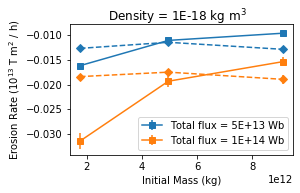

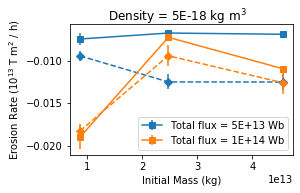

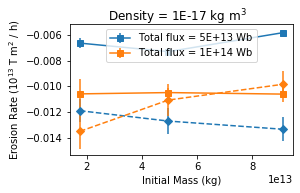

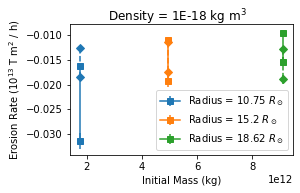

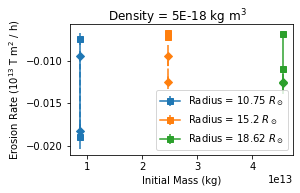

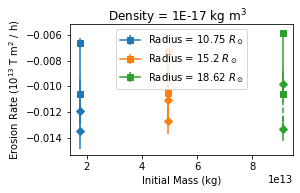

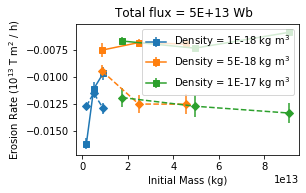

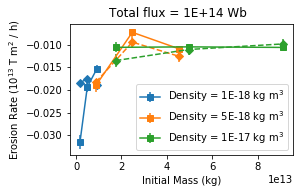

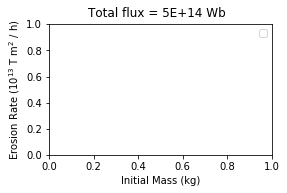

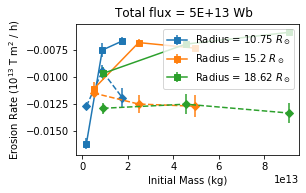

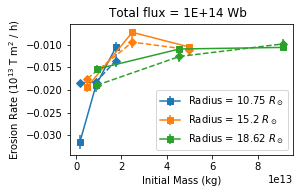

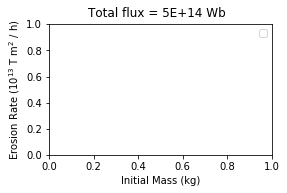

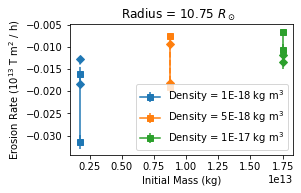

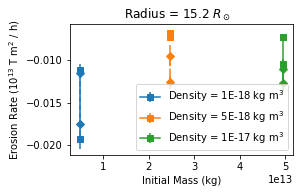

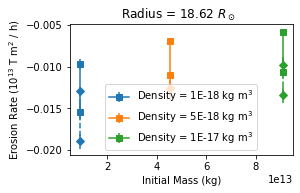

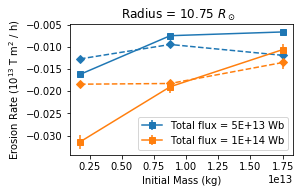

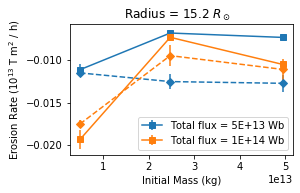

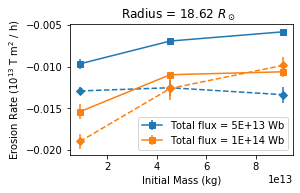

In [13]:
for pm1 in range(3):
    for pm2 in range(3):
        if pm2 == pm1:
            continue
        print(pm1, pm2)
        pm_study_mass(pm1, pm2, saveFig=False, save_folder_name="pm-study-B1-mass")
